# Frequency-Domain Master Curve Validation

Validate RheoJAX oscillatory fits using the PyVisco master curve dataset.

In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports
Use the PyVisco master-curve dataset to validate RheoJAX oscillatory fits and compare generalized vs fractional models.

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)
import arviz as az


INFO:2025-12-07 17:24:22,196:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load master-curve data

Files live in `examples/data/pyvisco/freq_master/` and include storage/loss moduli (MPa) plus tabulated shift factors.

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyvisco' / 'freq_master'
master_df = pd.read_csv(DATA_DIR / 'freq_user_master.csv')
shift_df = pd.read_csv(DATA_DIR / 'freq_user_master__shift_factors.csv')

# Drop units row and coerce numeric
master_clean = master_df.iloc[1:].astype(float)

# Frequency in Hz → angular freq (rad/s)
freq_hz = master_clean['f'].to_numpy()
omega = 2 * np.pi * freq_hz
G_prime = master_clean['E_stor'].to_numpy()
G_double = master_clean['E_loss'].to_numpy()
G_star = G_prime + 1j * G_double

data = RheoData(
    x=omega,
    y=G_star,
    x_units='rad/s',
    y_units='MPa',
    domain='oscillation',
    metadata={'source': 'pyvisco_master', 'test_mode': 'oscillation'}
)
print(data)

# Display shift factors for reference
shift_df.head()


RheoData(x=array([6.2832e-12, 7.5541e-12, 1.2537e-11, 1.6275e-11, 2.7009e-11,
       3.5063e-11, 5.2261e-11, 5.8190e-11, 7.5541e-11, 1.1259e-10,
       1.2537e-10, 1.6275e-10, 2.4258e-10, 2.7009e-10, 3.5063e-10,
       4.1513e-10, 5.2261e-10, 5.8190e-10, 7.5541e-10, 8.9436e-10,
       1.1259e-09, 1.2537e-09, 1.6275e-09, 1.9268e-09, 2.1786e-09,
       2.4258e-09, 3.5063e-09, 4.1513e-09, 4.6937e-09, 5.2261e-09,
       7.5541e-09, 8.9436e-09, 1.0112e-08, 1.1259e-08, 1.1434e-08,
       1.9268e-08, 2.1786e-08, 2.4258e-08, 2.4633e-08, 4.1513e-08,
       4.6937e-08, 5.2261e-08, 5.3070e-08, 6.0004e-08, 8.9436e-08,
       1.0112e-07, 1.1434e-07, 1.2927e-07, 1.9268e-07, 2.1786e-07,
       2.4633e-07, 2.7427e-07, 2.7851e-07, 4.1513e-07, 4.6937e-07,
       5.3070e-07, 5.9090e-07, 6.0004e-07, 1.0112e-06, 1.1434e-06,
       1.2731e-06, 1.2927e-06, 1.4394e-06, 2.1786e-06, 2.4633e-06,
       2.7427e-06, 2.7851e-06, 3.1011e-06, 5.3070e-06, 5.9090e-06,
       6.0004e-06, 6.6811e-06, 8.6732e-06, 1.1434e-

,T,log_aT
0,C,-
1,100,-11.7
2,92,-10.92
3,85,-10.08
4,77,-9.18


## Visualize raw master curve

In [4]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(freq_hz, G_prime, 'o', label="E' data")
ax.loglog(freq_hz, G_double, 's', label='E" data')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Modulus (MPa)')
ax.set_title('PyVisco master curve (storage/loss)')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend();


## Fit RheoJAX models

We compare a 6-mode generalized Maxwell model (Prony-style) against the fractional Maxwell model. Both use log-space residuals to respect the wide frequency range.

In [5]:
# Generalized Maxwell accepts complex modulus directly
gm = GeneralizedMaxwell(n_modes=6, modulus_type='tensile')
gm.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True, use_multi_start=True)
gm_pred_components = gm.predict(omega)
gm_pred = gm_pred_components[:, 0] + 1j * gm_pred_components[:, 1]
gm_r2 = r2_complex(G_star, gm_pred)

# Fractional Maxwell (fixed-parameter variant) with graceful fallback
fm_pred = np.full_like(G_star, np.nan)
fm_r2 = np.nan
try:
    fm = FractionalMaxwellModel()
    fm.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
    fm_pred = fm.predict(omega, test_mode='oscillation')
    fm_r2 = r2_complex(G_star, fm_pred)
except Exception as exc:
    print(f"Fractional Maxwell fit failed: {exc}")

print(f"Generalized Maxwell R^2: {gm_r2:.4f}")
print(f"Fractional Maxwell R^2:   {fm_r2 if np.isfinite(fm_r2) else float('nan'):.4f}")


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.150888s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=11 | final_cost=8.202934e+07 | time=1.151s | final_gradient_norm=764963094.0502862


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.271326s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=11 | final_cost=8.202934e+07 | time=0.271s | final_gradient_norm=764963094.0502862


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.872182s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=5.173173e+07 | time=0.872s | final_gradient_norm=32108.239563800467


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.896287s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=5.191221e+07 | time=0.896s | final_gradient_norm=7243582630624.692


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.872113s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=5.259350e+07 | time=0.872s | final_gradient_norm=26741633106283.24


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.821601s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=22 | final_cost=5.584291e+07 | time=0.822s | final_gradient_norm=23804802006578.42


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.765654s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=8.708424e+07 | time=0.766s | final_gradient_norm=711.11440157686


Element minimization: reducing from 6 to 2 modes


Auto-enabling multi-start optimization for very wide range (26.0 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.534958s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=4.726795e+20 | time=0.535s | final_gradient_norm=1.569008955428314e+30


Fractional Maxwell fit failed: Optimization failed: residual norm remains extremely large. Try providing better initial values, looser bounds, or scaling the data.
Generalized Maxwell R^2: 0.9190
Fractional Maxwell R^2:   nan


## Overlay fits vs data

/var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp/T/ipykernel_27868/3845240182.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best')


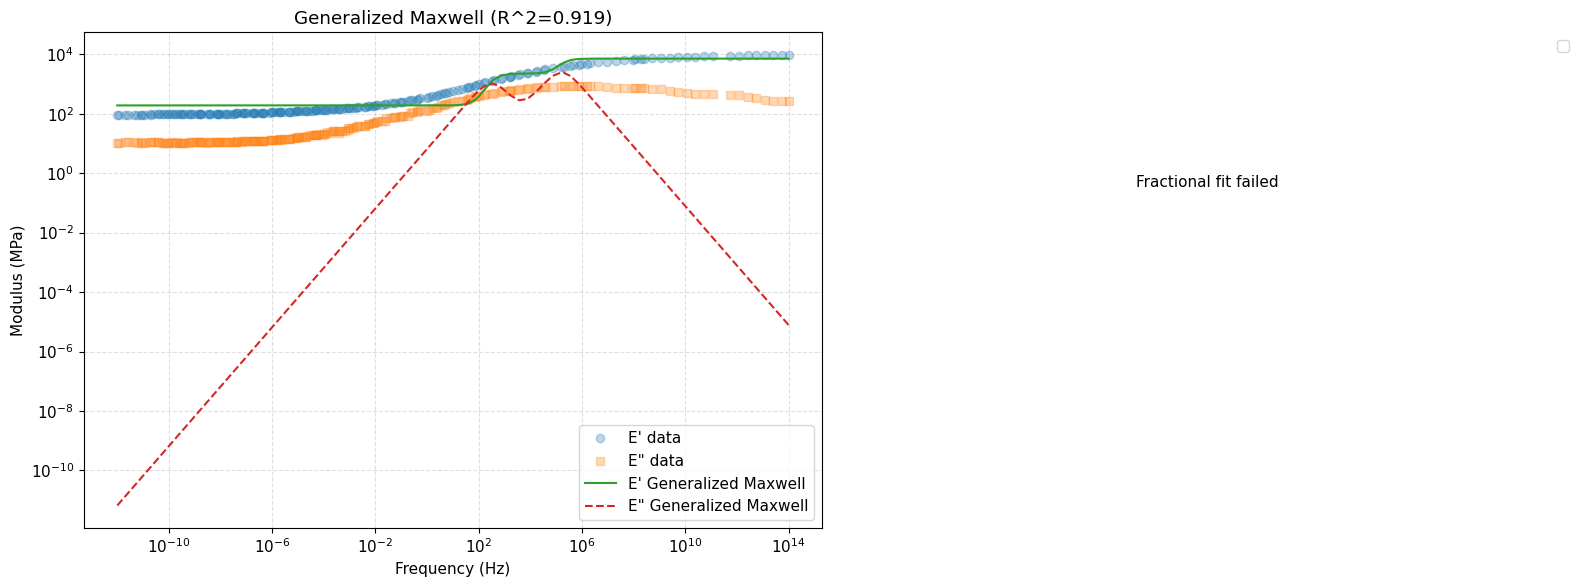

In [6]:
def plot_fit(ax, freq, data_complex, pred_complex, label):
    ax.loglog(freq, np.real(data_complex), 'o', alpha=0.3, label="E' data")
    ax.loglog(freq, np.imag(data_complex), 's', alpha=0.3, label='E" data')
    ax.loglog(freq, np.real(pred_complex), '-', label=f"E' {label}")
    ax.loglog(freq, np.imag(pred_complex), '--', label=f'E" {label}')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Modulus (MPa)')
    ax.grid(True, which='both', ls='--', alpha=0.4)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plot_fit(axes[0], freq_hz, G_star, gm_pred, 'Generalized Maxwell')
axes[0].set_title(f'Generalized Maxwell (R^2={gm_r2:.3f})')

if np.isfinite(fm_r2):
    plot_fit(axes[1], freq_hz, G_star, fm_pred, 'Fractional Maxwell')
    axes[1].set_title(f'Fractional Maxwell (R^2={fm_r2:.3f})')
else:
    axes[1].axis('off')
    axes[1].text(0.5, 0.5, 'Fractional fit failed', ha='center', va='center')

for ax in axes:
    ax.legend(loc='best')
plt.tight_layout()
display(fig)
plt.close(fig)

## Residual diagnostics

In [7]:
def residual_mpe(y_true, y_pred):
    res = y_true - y_pred
    mpe = np.mean(np.abs(res) / np.maximum(np.abs(y_true), 1e-12)) * 100
    return float(mpe)

gm_mpe = residual_mpe(G_star, gm_pred)
fm_mpe = residual_mpe(G_star, fm_pred) if np.isfinite(fm_r2) else np.nan
print({'gm_mpe_%': gm_mpe, 'fm_mpe_%': fm_mpe})

{'gm_mpe_%': 57.71232110218008, 'fm_mpe_%': nan}


## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Auto-enabling multi-start optimization for very wide range (26.0 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.294528s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=45 | final_cost=5.584293e+07 | time=0.295s | final_gradient_norm=13114.302830619676


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.300849s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=45 | final_cost=5.584293e+07 | time=0.301s | final_gradient_norm=13114.302830619676


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.199955s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=8.708424e+07 | time=0.200s | final_gradient_norm=710.7175611834908


Element minimization: early termination at n_modes=1 (R²=0.886189 < threshold=0.890528)


Auto-enabling multi-start optimization for very wide range (26.0 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.188128s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=4.726795e+20 | time=0.188s | final_gradient_norm=1.569008955428314e+30


Skipping fm due to fit error: Optimization failed: residual norm remains extremely large. Try providing better initial values, looser bounds, or scaling the data.
Model ranking (R²): [('gm', 0.919)]


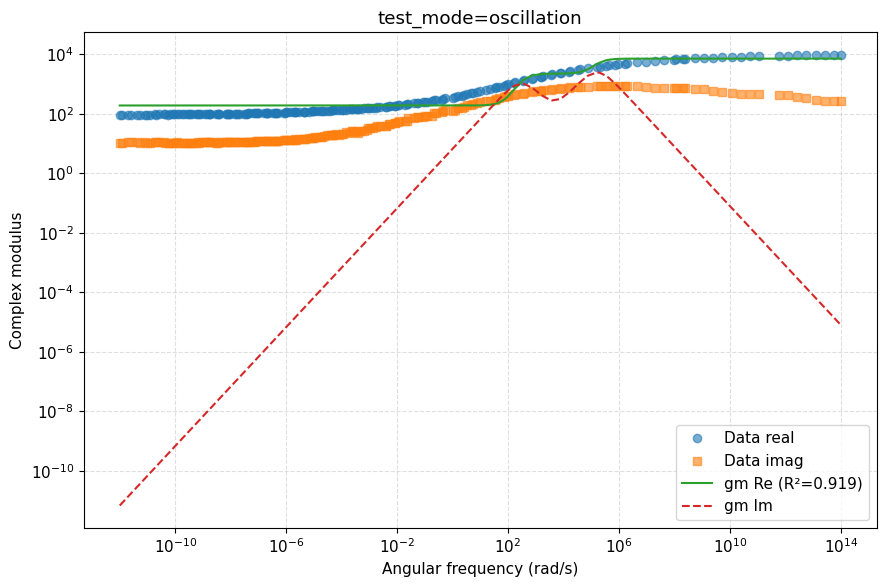

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<47:36,  1.40it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|▏         | 50/4000 [00:00<00:47, 82.56it/s, 127 steps of size 3.69e-02. acc. prob=0.75]

warmup:   4%|▎         | 142/4000 [00:00<00:15, 243.03it/s, 7 steps of size 6.08e-01. acc. prob=0.78]

warmup:   9%|▉         | 379/4000 [00:01<00:05, 700.09it/s, 15 steps of size 3.61e-01. acc. prob=0.78]

warmup:  16%|█▌        | 620/4000 [00:01<00:03, 1101.43it/s, 7 steps of size 4.04e-01. acc. prob=0.79]

warmup:  22%|██▏       | 875/4000 [00:01<00:02, 1463.94it/s, 15 steps of size 3.00e-01. acc. prob=0.79]

sample:  28%|██▊       | 1114/4000 [00:01<00:01, 1707.59it/s, 15 steps of size 2.74e-01. acc. prob=0.90]

sample:  34%|███▍      | 1350/4000 [00:01<00:01, 1885.83it/s, 7 steps of size 2.74e-01. acc. prob=0.91] 

sample:  40%|███▉      | 1590/4000 [00:01<00:01, 2029.18it/s, 15 steps of size 2.74e-01. acc. prob=0.91]

sample:  46%|████▌     | 1830/4000 [00:01<00:01, 2134.21it/s, 15 steps of size 2.74e-01. acc. prob=0.90]

sample:  52%|█████▏    | 2071/4000 [00:01<00:00, 2213.35it/s, 15 steps of size 2.74e-01. acc. prob=0.90]

sample:  58%|█████▊    | 2308/4000 [00:01<00:00, 2258.84it/s, 15 steps of size 2.74e-01. acc. prob=0.90]

sample:  64%|██████▎   | 2549/4000 [00:01<00:00, 2301.69it/s, 15 steps of size 2.74e-01. acc. prob=0.90]

sample:  70%|██████▉   | 2786/4000 [00:02<00:00, 2315.41it/s, 15 steps of size 2.74e-01. acc. prob=0.90]

sample:  76%|███████▌  | 3022/4000 [00:02<00:00, 2312.16it/s, 15 steps of size 2.74e-01. acc. prob=0.90]

sample:  82%|████████▏ | 3262/4000 [00:02<00:00, 2335.16it/s, 15 steps of size 2.74e-01. acc. prob=0.90]

sample:  87%|████████▋ | 3498/4000 [00:02<00:00, 2331.73it/s, 15 steps of size 2.74e-01. acc. prob=0.90]

sample:  94%|█████████▎| 3740/4000 [00:02<00:00, 2356.89it/s, 15 steps of size 2.74e-01. acc. prob=0.90]

sample:  99%|█████████▉| 3977/4000 [00:02<00:00, 2358.37it/s, 15 steps of size 2.74e-01. acc. prob=0.90]

sample: 100%|██████████| 4000/4000 [00:02<00:00, 1578.05it/s, 15 steps of size 2.74e-01. acc. prob=0.90]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   2%|▏         | 69/4000 [00:00<00:05, 683.53it/s, 255 steps of size 4.29e-02. acc. prob=0.76]

warmup:   6%|▌         | 221/4000 [00:00<00:03, 1172.10it/s, 7 steps of size 2.95e-01. acc. prob=0.78]

warmup:  12%|█▏        | 487/4000 [00:00<00:01, 1849.07it/s, 3 steps of size 1.89e-01. acc. prob=0.79]

warmup:  19%|█▉        | 760/4000 [00:00<00:01, 2193.30it/s, 15 steps of size 5.06e-01. acc. prob=0.79]

sample:  26%|██▌       | 1028/4000 [00:00<00:01, 2367.39it/s, 15 steps of size 2.79e-01. acc. prob=0.87]

sample:  32%|███▏      | 1265/4000 [00:00<00:01, 2359.60it/s, 7 steps of size 2.79e-01. acc. prob=0.90] 

sample:  38%|███▊      | 1502/4000 [00:00<00:01, 2334.20it/s, 15 steps of size 2.79e-01. acc. prob=0.91]

sample:  43%|████▎     | 1736/4000 [00:00<00:00, 2335.63it/s, 7 steps of size 2.79e-01. acc. prob=0.91] 

sample:  49%|████▉     | 1971/4000 [00:00<00:00, 2337.81it/s, 15 steps of size 2.79e-01. acc. prob=0.91]

sample:  55%|█████▌    | 2205/4000 [00:01<00:00, 2336.86it/s, 15 steps of size 2.79e-01. acc. prob=0.91]

sample:  61%|██████    | 2439/4000 [00:01<00:00, 2331.67it/s, 15 steps of size 2.79e-01. acc. prob=0.91]

sample:  67%|██████▋   | 2678/4000 [00:01<00:00, 2348.16it/s, 15 steps of size 2.79e-01. acc. prob=0.92]

sample:  73%|███████▎  | 2913/4000 [00:01<00:00, 2344.98it/s, 15 steps of size 2.79e-01. acc. prob=0.92]

sample:  79%|███████▊  | 3148/4000 [00:01<00:00, 2345.88it/s, 7 steps of size 2.79e-01. acc. prob=0.92] 

sample:  85%|████████▍ | 3387/4000 [00:01<00:00, 2358.88it/s, 15 steps of size 2.79e-01. acc. prob=0.92]

sample:  91%|█████████ | 3623/4000 [00:01<00:00, 2354.37it/s, 7 steps of size 2.79e-01. acc. prob=0.92] 

sample:  96%|█████████▋| 3859/4000 [00:01<00:00, 2354.50it/s, 15 steps of size 2.79e-01. acc. prob=0.92]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2260.92it/s, 15 steps of size 2.79e-01. acc. prob=0.92]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|▏         | 55/4000 [00:00<00:07, 543.95it/s, 63 steps of size 6.96e-02. acc. prob=0.76]

warmup:   4%|▍         | 177/4000 [00:00<00:04, 938.49it/s, 7 steps of size 1.03e+00. acc. prob=0.78]

warmup:  11%|█         | 421/4000 [00:00<00:02, 1621.09it/s, 31 steps of size 2.26e-01. acc. prob=0.79]

warmup:  16%|█▋        | 655/4000 [00:00<00:01, 1903.02it/s, 15 steps of size 3.47e-01. acc. prob=0.79]

warmup:  23%|██▎       | 925/4000 [00:00<00:01, 2188.05it/s, 15 steps of size 3.91e-01. acc. prob=0.79]

sample:  29%|██▉       | 1169/4000 [00:00<00:01, 2271.14it/s, 15 steps of size 3.01e-01. acc. prob=0.91]

sample:  35%|███▌      | 1413/4000 [00:00<00:01, 2323.07it/s, 15 steps of size 3.01e-01. acc. prob=0.92]

sample:  41%|████▏     | 1657/4000 [00:00<00:00, 2359.58it/s, 7 steps of size 3.01e-01. acc. prob=0.93] 

sample:  48%|████▊     | 1903/4000 [00:00<00:00, 2390.78it/s, 15 steps of size 3.01e-01. acc. prob=0.92]

sample:  54%|█████▎    | 2147/4000 [00:01<00:00, 2404.86it/s, 15 steps of size 3.01e-01. acc. prob=0.93]

sample:  60%|█████▉    | 2395/4000 [00:01<00:00, 2425.97it/s, 15 steps of size 3.01e-01. acc. prob=0.92]

sample:  66%|██████▌   | 2641/4000 [00:01<00:00, 2436.12it/s, 15 steps of size 3.01e-01. acc. prob=0.93]

sample:  72%|███████▏  | 2898/4000 [00:01<00:00, 2474.95it/s, 15 steps of size 3.01e-01. acc. prob=0.92]

sample:  79%|███████▉  | 3150/4000 [00:01<00:00, 2486.95it/s, 7 steps of size 3.01e-01. acc. prob=0.93] 

sample:  85%|████████▍ | 3399/4000 [00:01<00:00, 2479.07it/s, 15 steps of size 3.01e-01. acc. prob=0.93]

sample:  91%|█████████ | 3647/4000 [00:01<00:00, 2456.71it/s, 3 steps of size 3.01e-01. acc. prob=0.93] 

sample:  97%|█████████▋| 3893/4000 [00:01<00:00, 2442.72it/s, 7 steps of size 3.01e-01. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2258.07it/s, 15 steps of size 3.01e-01. acc. prob=0.93]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   2%|▏         | 73/4000 [00:00<00:05, 713.69it/s, 191 steps of size 2.09e-02. acc. prob=0.76]

warmup:   5%|▍         | 195/4000 [00:00<00:03, 1007.80it/s, 7 steps of size 3.66e-01. acc. prob=0.78]

warmup:  11%|█         | 424/4000 [00:00<00:02, 1589.69it/s, 15 steps of size 3.16e-01. acc. prob=0.79]

warmup:  16%|█▋        | 655/4000 [00:00<00:01, 1872.88it/s, 15 steps of size 3.07e-01. acc. prob=0.79]

warmup:  22%|██▎       | 900/4000 [00:00<00:01, 2080.27it/s, 15 steps of size 2.03e-01. acc. prob=0.79]

sample:  28%|██▊       | 1130/4000 [00:00<00:01, 2153.13it/s, 15 steps of size 2.60e-01. acc. prob=0.97]

sample:  34%|███▍      | 1359/4000 [00:00<00:01, 2196.63it/s, 15 steps of size 2.60e-01. acc. prob=0.96]

sample:  40%|███▉      | 1589/4000 [00:00<00:01, 2228.49it/s, 15 steps of size 2.60e-01. acc. prob=0.96]

sample:  45%|████▌     | 1816/4000 [00:00<00:00, 2240.12it/s, 15 steps of size 2.60e-01. acc. prob=0.96]

sample:  51%|█████     | 2044/4000 [00:01<00:00, 2249.46it/s, 15 steps of size 2.60e-01. acc. prob=0.96]

sample:  57%|█████▋    | 2280/4000 [00:01<00:00, 2281.48it/s, 15 steps of size 2.60e-01. acc. prob=0.96]

sample:  63%|██████▎   | 2509/4000 [00:01<00:00, 2277.98it/s, 31 steps of size 2.60e-01. acc. prob=0.96]

sample:  69%|██████▊   | 2743/4000 [00:01<00:00, 2295.83it/s, 15 steps of size 2.60e-01. acc. prob=0.96]

sample:  74%|███████▍  | 2973/4000 [00:01<00:00, 2295.46it/s, 15 steps of size 2.60e-01. acc. prob=0.96]

sample:  80%|████████  | 3203/4000 [00:01<00:00, 2296.55it/s, 15 steps of size 2.60e-01. acc. prob=0.96]

sample:  86%|████████▌ | 3438/4000 [00:01<00:00, 2309.94it/s, 15 steps of size 2.60e-01. acc. prob=0.96]

sample:  92%|█████████▏| 3674/4000 [00:01<00:00, 2321.70it/s, 31 steps of size 2.60e-01. acc. prob=0.96]

sample:  98%|█████████▊| 3908/4000 [00:01<00:00, 2325.52it/s, 7 steps of size 2.60e-01. acc. prob=0.96] 

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2164.10it/s, 15 steps of size 2.60e-01. acc. prob=0.96]

array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='tau_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_2'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_inf'>, <Axes: xlabel='sigma_imag'>,
        <Axes: xlabel='sigma_real'>, <Axes: xlabel='tau_1'>]],
      dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'center': 'E_inf\n2'}>,
        <Axes: title={'center': 'E_inf\n3'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_imag\n1'}>,
        <Axes: title={'center': 'sigma_imag\n2'}>,
        <Axes: title={'center': 'sigma_imag\n3'}>],
       [<Axes: title={'center': 'sigma_real\n0'}>,
        <Axes: title={'center': 'sigma_real\n1'}>,
        <Axes: title={'center': 'sigma_real\n2'}>,
        <Axes: title={'center': 'sigma_real\n3'}>],
       [<Axes: title={'center': 'tau_1\n0'}>,
     

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >, <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: >, <Axes: >]], dtype=object)

In [8]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
